In [1]:
# Cell 1: Install dependencies (run this first!)
!pip install numpy==2.2.4
!pip install catboost transformers torch tqdm pandas scikit-learn shap


In [2]:
## Cell 2: Imports & Module Paths
import os
import numpy as np
import pandas as pd



from recruitment_fairness.data.loader import ClinicalTrialsWebCollector
from recruitment_fairness.data.preprocess import ClinicalTrialPreprocessor
from recruitment_fairness.data.clinicalbert_embedder import ClinicalBERTEmbedder
from recruitment_fairness.models.catboost_net import CatBoostNet
from recruitment_fairness.models.fairness_utils import (
    demographic_parity_difference,
    equal_opportunity_difference,
)
from catboost import Pool


d:\Sem2\Research paper last round\projectcode\FinalProject\recruitment_fairness\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Cell 3: Data Collection (fetch ~1,500 trials)
collector = ClinicalTrialsWebCollector(output_dir="data/raw")
df = collector.search_trials(query_term="", max_studies=1500)  # blank = all conditions

print("Raw data shape:", df.shape)
df.head(3)


Fetching all: 100%|██████████| 1500/1500 [00:09<00:00, 165.51it/s]

✅ 1500 trials saved to data\raw\raw_clinical_trials_20250724_235359.csv
Raw data shape: (1500, 23)


,sponsor,sponsor_class,nct_id,brief_title,official_title,brief_summary,detailed_description,overall_status,why_stopped,start_date,...,phases,allocation,intervention_model,masking,primary_purpose,enrollment_count,enrollment_type,interventions_json,interventions_types,interventions_names
0,Montefiore Medical Center,OTHER,NCT05013879,Kinesiotape for Edema After Bilateral Total Kn...,"Effect of Kinesiotaping on Edema Management, P...",The purpose of this study is to determine if k...,After being informed about the study and poten...,COMPLETED,,2021-10-18,...,NA,RANDOMIZED,SINGLE_GROUP,NONE,TREATMENT,65,ACTUAL,"[{""name"": ""Kinesio(R)Tape for edema control"", ...",DEVICE,Kinesio(R)Tape for edema control
1,"Hospital Authority, Hong Kong",OTHER_GOV,NCT00517179,Effect of Vardenafil on Blood Pressure in Pati...,Effect of Vardenafil on Blood Pressure in Pati...,The purpose of this study is to investigate th...,,COMPLETED,,2006-04,...,NA,RANDOMIZED,CROSSOVER,DOUBLE,TREATMENT,40,ESTIMATED,"[{""name"": ""Vardenafil 10mg"", ""type"": ""DRUG"", ""...",DRUG,Vardenafil 10mg
2,"Royal College of Surgeons, Ireland",OTHER,NCT06714279,Laparoscopic-Assisted Transversus Abdominus Pl...,Laparoscopic-Assisted Transversus Abdominus Pl...,This study is being performed to investigate w...,Laparoscopic cholecystectomy remains the corne...,NOT_YET_RECRUITING,,2025-01,...,PHASE1,RANDOMIZED,PARALLEL,NONE,TREATMENT,144,ESTIMATED,"[{""name"": ""Tap Block - Bupivacaine"", ""type"": ""...",DRUG;DRUG,Tap Block - Bupivacaine;Intraperitoneal infilt...


In [4]:
## Cell 4: Preprocessing & Train/Val/Test Split

preproc = ClinicalTrialPreprocessor(data_dir="data/raw", processed_dir="data/processed")
train, val, test = preproc.preprocess(df)

print(f"Splits — train: {len(train)}, val: {len(val)}, test: {len(test)}")
train.head(3)


Splits: train=1080, val=120, test=300
Splits — train: 1080, val: 120, test: 300


,sponsor_class,nct_id,brief_title,official_title,brief_summary,detailed_description,overall_status,why_stopped,start_date,completion_date,...,allocation,intervention_model,masking,primary_purpose,enrollment_count,enrollment_type,interventions_json,interventions_types,interventions_names,is_success
1197,OTHER,NCT06147479,Cognitive Stimulation in Daily Activities for ...,Cognitive Stimulation in Activities of Daily L...,The goal of this study is to test the effect o...,,COMPLETED,,2023-11-03,2024-06-21,...,RANDOMIZED,PARALLEL,SINGLE,SUPPORTIVE_CARE,16,ACTUAL,"[{""name"": ""CS-ADL (Cognitive stimulation in Ac...",BEHAVIORAL,cs-adl (cognitive stimulation in activities of...,1
658,OTHER,NCT05844579,The ICU LIBERATION Study,ReLatIonship BEtween Implementation of Evidenc...,Acute respiratory distress syndrome (ARDS) is ...,Background:\n\nAcute respiratory distress synd...,RECRUITING,,2023-06-01,2031-12-31,...,,,,,1000,ESTIMATED,[],,,0
1150,OTHER,NCT04461379,"Prevention, Efficacy and Safety of BCG Vaccine...","Prevention, Efficacy and Safety of BCG Vaccine...",In Mexico the total number of confirmed cases ...,"The study design is a randomized, double-blind...",UNKNOWN,,2020-07-21,2021-01-01,...,RANDOMIZED,PARALLEL,TRIPLE,PREVENTION,908,ESTIMATED,"[{""name"": ""BCG vaccine"", ""type"": ""BIOLOGICAL"",...",BIOLOGICAL;OTHER,bcg vaccine;placebo,0


In [5]:
## Cell 5: Structured Feature Engineering


# get structured features + cat feature indices
X_tr_struct, cat_idx = preproc.get_structured_features(train)
X_va_struct, _       = preproc.get_structured_features(val)
X_te_struct, _       = preproc.get_structured_features(test)

print("Structured columns:", X_tr_struct.columns.tolist())
print("Cat feature indices:", cat_idx)
print("Cat feature names:", [X_tr_struct.columns[i] for i in cat_idx])


Structured columns: ['phase_EARLY_PHASE1', 'phase_NA', 'phase_PHASE1', 'phase_PHASE1|PHASE2', 'phase_PHASE2', 'phase_PHASE2|PHASE3', 'phase_PHASE3', 'phase_PHASE4', 'phase_unknown', 'sponsor_class', 'enrollment_count']
Cat feature indices: [9]
Cat feature names: ['sponsor_class']


In [6]:
## Cell 6: ClinicalBERT Embeddings for Brief Summary

embedder = ClinicalBERTEmbedder()
texts_tr = train["brief_summary"].fillna("").astype(str).tolist()
texts_va = val["brief_summary"].fillna("").astype(str).tolist()
texts_te = test["brief_summary"].fillna("").astype(str).tolist()

X_tr_text = embedder.embed_texts(texts_tr, batch_size=16, max_length=128)
X_va_text = embedder.embed_texts(texts_va, batch_size=16, max_length=128)
X_te_text = embedder.embed_texts(texts_te, batch_size=16, max_length=128)

print("Text embedding dims:", X_tr_text.shape, X_va_text.shape, X_te_text.shape)


Embedding texts: 100%|██████████| 19/19 [00:30<00:00,  1.59s/it]

Text embedding dims: (1080, 768) (120, 768) (300, 768)


In [7]:
## Cell 7: Assemble Feature DataFrames & Pools


# 7.1 Build text DataFrames in one go to avoid fragmentation
text_cols = [f"text_{i}" for i in range(X_tr_text.shape[1])]

df_tr_text = pd.DataFrame(X_tr_text, columns=text_cols, index=X_tr_struct.index)
df_va_text = pd.DataFrame(X_va_text, columns=text_cols, index=X_va_struct.index)
df_te_text = pd.DataFrame(X_te_text, columns=text_cols, index=X_te_struct.index)

# 7.2 Concatenate structured + text into single DataFrame
X_tr_df = pd.concat([X_tr_struct, df_tr_text], axis=1)
X_va_df = pd.concat([X_va_struct, df_va_text], axis=1)
X_te_df = pd.concat([X_te_struct, df_te_text], axis=1)

# 🔧 Align columns so train/val/test have the same feature set
X_va_df = X_va_df.reindex(columns=X_tr_df.columns, fill_value=0)
X_te_df = X_te_df.reindex(columns=X_tr_df.columns, fill_value=0)

# 7.3 Build CatBoost Pools
train_pool = Pool(data=X_tr_df, label=train["is_success"].to_numpy(),
                  cat_features=["sponsor_class"])
val_pool   = Pool(data=X_va_df, label=val["is_success"].to_numpy(),
                  cat_features=["sponsor_class"])
print("Pools ready. Example row:\n", X_tr_df.iloc[0])


Pools ready. Example row:
 phase_EARLY_PHASE1        False
phase_NA                   True
phase_PHASE1              False
phase_PHASE1|PHASE2       False
phase_PHASE2              False
                         ...   
text_763               0.197958
text_764              -0.036265
text_765              -0.202901
text_766               0.139219
text_767              -0.316161
Name: 1197, Length: 779, dtype: object


In [8]:
## Cell 8: Train RecruitmentNet (CatBoost)

cb = CatBoostNet(
    cat_features=["sponsor_class"], 
    iterations=300, depth=6, learning_rate=0.05, random_state=42, early_stopping_rounds=30
)
cb.model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    verbose=50
)

# Evaluate on test
y_pred_proba = cb.model.predict_proba(X_te_df)[:, 1]
y_pred       = (y_pred_proba > 0.5).astype(int)
print("Sample predictions:", y_pred_proba[:5])


0:	test: 0.4626824	best: 0.4626824 (0)	total: 372ms	remaining: 1m 51s
50:	test: 0.5878227	best: 0.6377666 (25)	total: 7.69s	remaining: 37.5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6377665544
bestIteration = 25

Shrink model to first 26 iterations.
Sample predictions: [0.4221863  0.62795953 0.60113188 0.51533316 0.54196326]


In [9]:
## Cell 9: Fairness Metrics on RecruitmentNet

sens_attr = test["sponsor_class"].to_numpy()
dp = demographic_parity_difference(test["is_success"].to_numpy(), y_pred, sens_attr)
eo = equal_opportunity_difference(test["is_success"].to_numpy(), y_pred, sens_attr)
print(f"RecruitmentNet Demographic Parity ΔP = {dp:.3f}")
print(f"RecruitmentNet Equal Opp. ΔTPR = {eo:.3f}")


RecruitmentNet Demographic Parity ΔP = 0.224
RecruitmentNet Equal Opp. ΔTPR = 0.344


In [10]:
## Cell 10: Train FairOutcomeNet (Second Stage)

# 10.1 Extend features with recruitment score
recruit_score_tr = cb.model.predict_proba(X_tr_df)[:, 1].reshape(-1,1)
recruit_score_va = cb.model.predict_proba(X_va_df)[:, 1].reshape(-1,1)
recruit_score_te = cb.model.predict_proba(X_te_df)[:, 1].reshape(-1,1)

X2_tr_df = pd.concat([
    X_tr_df, 
    pd.DataFrame(recruit_score_tr, columns=["recruit_score"], index=X_tr_df.index)
], axis=1)
X2_va_df = pd.concat([
    X_va_df, 
    pd.DataFrame(recruit_score_va, columns=["recruit_score"], index=X_va_df.index)
], axis=1)
X2_te_df = pd.concat([
    X_te_df, 
    pd.DataFrame(recruit_score_te, columns=["recruit_score"], index=X_te_df.index)
], axis=1)

# 10.2 Build Pools
train2 = Pool(data=X2_tr_df, label=train["is_success"].to_numpy(),
              cat_features=["sponsor_class"])
val2   = Pool(data=X2_va_df, label=val["is_success"].to_numpy(),
              cat_features=["sponsor_class"])

# 10.3 Fit second‐stage model
cb2 = CatBoostNet(
    cat_features=["sponsor_class"], 
    iterations=300, depth=6, learning_rate=0.05, random_state=42, early_stopping_rounds=30
)
cb2.model.fit(train2, eval_set=val2, use_best_model=True, verbose=50)


0:	test: 0.6177048	best: 0.6177048 (0)	total: 156ms	remaining: 46.6s
50:	test: 0.6422559	best: 0.6498316 (23)	total: 6.57s	remaining: 32.1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6498316498
bestIteration = 23

Shrink model to first 24 iterations.


In [11]:
## Cell 11: Fairness Metrics on FairOutcomeNet

y2_pred_proba = cb2.model.predict_proba(X2_te_df)[:, 1]
y2_pred       = (y2_pred_proba > 0.5).astype(int)

dp2 = demographic_parity_difference(test["is_success"].to_numpy(), y2_pred, sens_attr)
eo2 = equal_opportunity_difference(test["is_success"].to_numpy(), y2_pred, sens_attr)
print(f"FairOutcomeNet ΔP = {dp2:.3f}, ΔTPR = {eo2:.3f}")


FairOutcomeNet ΔP = 0.062, ΔTPR = 0.122


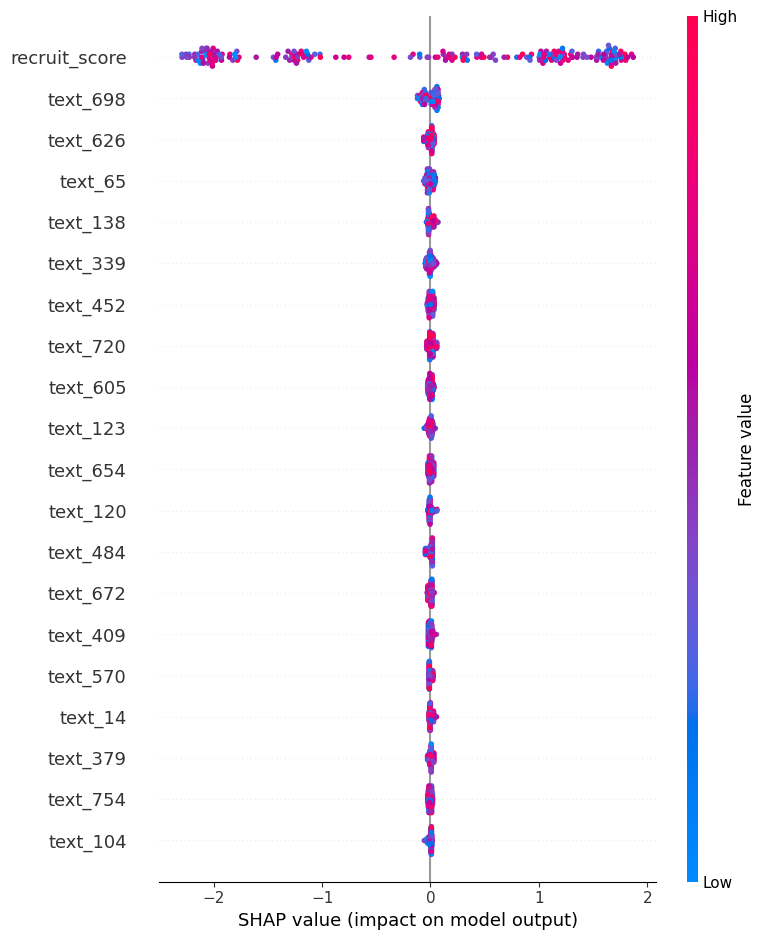

In [12]:
## Cell 12: SHAP Interpretability (optional)

import shap
# use a small sample for speed
explainer = shap.TreeExplainer(cb2.model)
shap_values = explainer.shap_values(X2_te_df.sample(200))
shap.summary_plot(shap_values, X2_te_df.sample(200))


Explaining samples at indices: [194, 939]


--- SHAP Waterfall for sample index 194 ---


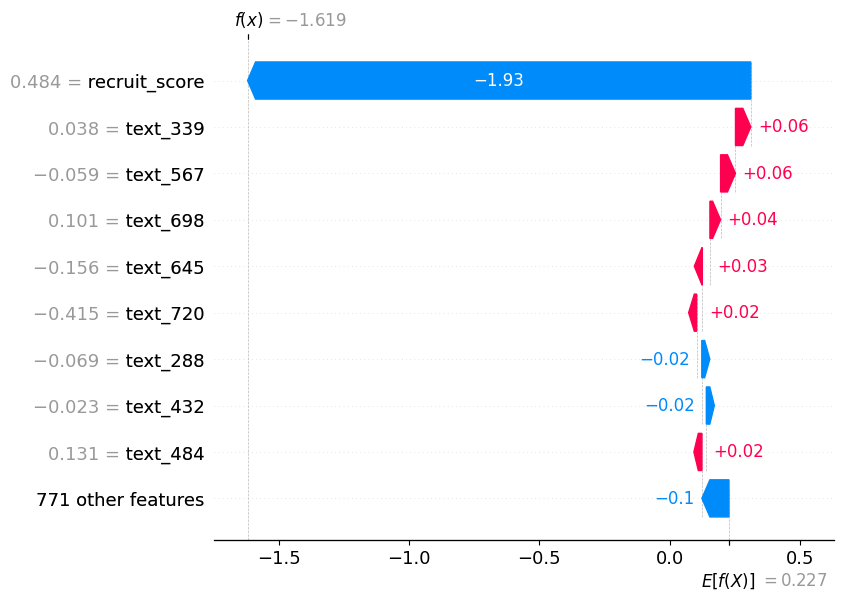



--- SHAP Waterfall for sample index 939 ---


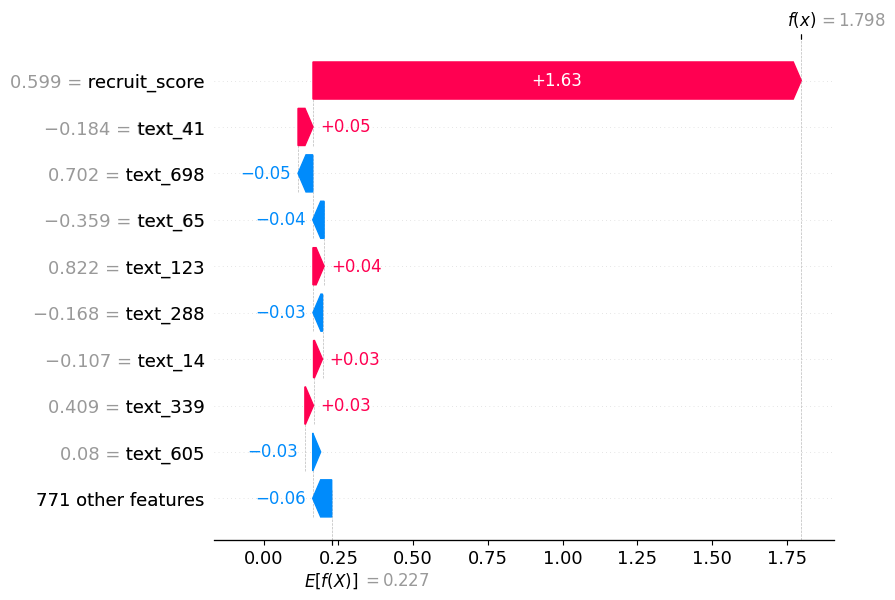

In [17]:
## Cell XX: Per-Sample SHAP Waterfall Plots

import shap

# 1) Initialize JS support (for force/interactive plots)
shap.initjs()

# 2) Create an explainer from your trained FairOutcomeNet model (CatBoost)
explainer = shap.TreeExplainer(cb2.model)

# 3) Select two random samples (or use specific indices)
sample_idxs = X2_te_df.sample(2, random_state=42).index.tolist()
print("Explaining samples at indices:", sample_idxs)

# 4) Compute SHAP values for those rows
#    shap_values.values will be a matrix of shape (n_samples, n_features)
shap_values = explainer.shap_values(X2_te_df.loc[sample_idxs])

# 5) Plot a waterfall for each
for i, idx in enumerate(sample_idxs):
    print(f"\n\n--- SHAP Waterfall for sample index {idx} ---")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[i],
            base_values=explainer.expected_value,
            data=X2_te_df.loc[idx],
            feature_names=X2_te_df.columns
        ),
        max_display=10  # show top 10 features
    )
